# Creating a data set for the comparison with Huppenkothen+2017

Main classificatin experiments described in paper Orwat-Kapola+2021 were not directly comparable with the work of Daniela Huppenkothen, because the former classified whole light curves instead of 1024 s segments, and the cadence of the data was 1s/4s instead of 0.125 s.

Here we prepare a data set of 1024 s overlapping segments which are be further segmented into 16 s segments with cadence of 0.125s to make a direct comparison with Huppenkothen+2017.

In order to reduce the amount of generated data, the 1024 s segments created with a stride of 256 s and the 16 s segments are created with a stride of 16 s. The fact that light curve features are observed in only one phase shift position within those 16 s segments can affect the result. 

Huppenkothen+2017 used a total of 1884 previously classified samples, with 885 classified samples in the training set, 480 samples in the validation set and 519 samples in the test set, respectively.

In [1]:
%load_ext autoreload
%autoreload 2

import sys; sys.path.insert(0, '../') # add parent folder path where /src folder is
from src import data_preprocessing

from IPython.display import clear_output
import os
import fnmatch
import numpy as np
# import pickle
# import matplotlib.pyplot as plt

data_dir = "../../data_GRS1915/"
raw_data_dir = "../../data_GRS1915/std1/" # directory path to where lightcurve files are located
raw_file_name_suffix = "_std1_lc.txt" # light curves were saved as txt files which are directly interpretable by numpy

In [2]:
# load light curves from text files

lcs=[] # light curves (time stamps, count rate, uncertainty)
lc_ids=[] # observation ids

for root, dirnames, filenames in os.walk(raw_data_dir): #Std1_PCU2
    for filename in fnmatch.filter(filenames, "*{}".format(raw_file_name_suffix)):
        lc = os.path.join(root, filename)
        lc_ids.append(filename.split("_")[0])
        f=np.loadtxt(lc)
        f=np.transpose(f)
        lcs.append(f)
        print("Loaded {} lightcurves".format(len(lcs)))
        clear_output(wait=True)

Loaded 1776 lightcurves


In [4]:
# segmentation of light curves

segments_counts=[]
segments_times = []
segments_errors=[]
seg_ids=[]

for lc_index, lc in enumerate(lcs):
    segments = data_preprocessing.segmentation(time_series = lc, 
                                       segment_length_sec = 1024, 
                                       stride_sec = 256, 
                                       keep_time_stamps = True, 
                                       input_cadence_sec = 0.125)
    if len(segments) > 0:
        segments_times.append(segments[:,0,:])
        segments_counts.append(segments[:,1,:])
        segments_errors.append(segments[:,2,:])
        for seg_index, seg in enumerate(segments):
            seg_ids.append(lc_ids[lc_index]+"_{}".format(seg_index))
            
    clear_output(wait=True)
    print("Processed {}/{} light curves.".format(lc_index+1, len(lcs)))
print("Successfully segmented {} light curves.".format(len(segments_times)))

segments_counts=np.vstack(segments_counts)
segments_errors=np.vstack(segments_errors)
segments_counts = np.expand_dims(segments_counts, axis=-1)
segments_errors = np.expand_dims(segments_errors, axis=-1)

print("Prepared {} segments.".format(len(segments_counts)))

Processed 1776/1776 light curves.
Successfully segmented 1435 light curves.
Prepared 10962 segments.


In [7]:
# load human-labelled classifications from Huppenkothen+2017

clean_belloni = open('{}/1915Belloniclass_updated.dat'.format(data_dir))
lines = clean_belloni.readlines()
states = lines[0].split()
belloni_clean = {}
for h,l in zip(states, lines[1:]):
    belloni_clean[h] = l.split()
    #state: obsID1, obsID2...
ob_state = {}
for state, obs in belloni_clean.items():
    if state == "chi1" or state == "chi2" or state == "chi3" or state == "chi4": state = "chi"
    for ob in obs:
        ob_state[ob] = state

        
# inverse the ob_state dictionary, so that inv_ob_state contains {"state name" : [list of observation IDs], ...}

inv_ob_state = {}
for k, v in ob_state.items():
    inv_ob_state[v] = inv_ob_state.get(v, [])
    inv_ob_state[v].append(k)

10408-01-16-04 theta


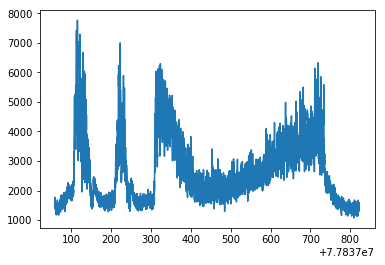

sum of GTI durations in seconds:  762.75



40703-01-33-02 delta


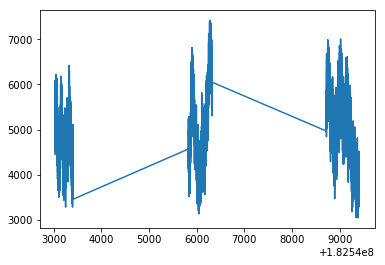

sum of GTI durations in seconds:  1575.75
individual GTI durations in seconds:
383.875
499.5
692.25



30703-01-28-01 rho


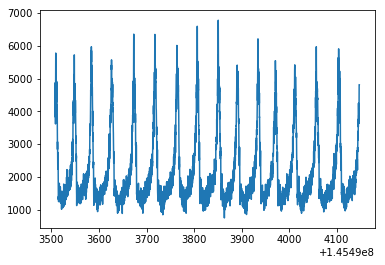

sum of GTI durations in seconds:  639.875



10408-01-14-05 delta


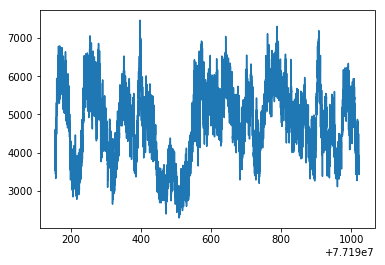

sum of GTI durations in seconds:  868.375



20402-01-36-01 lambda


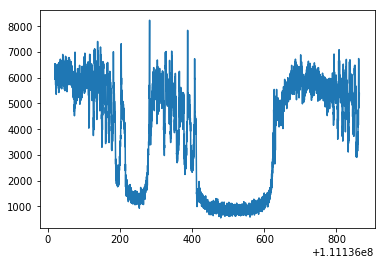

sum of GTI durations in seconds:  843.875



10408-01-09-00 phi
No data



10408-01-14-01 delta


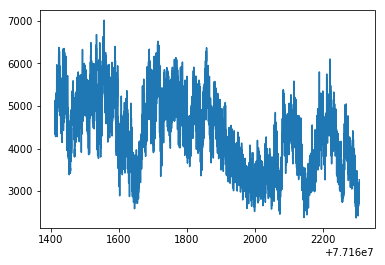

sum of GTI durations in seconds:  895.875



40703-01-14-01 kappa


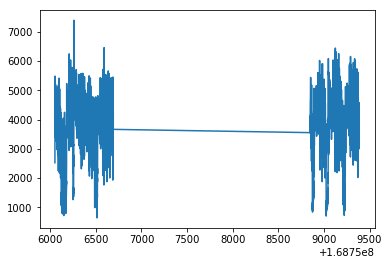

sum of GTI durations in seconds:  1175.75
individual GTI durations in seconds:
639.875
535.875



40703-01-42-01 chi


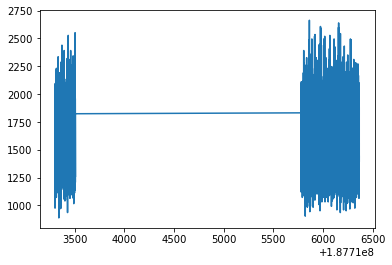

sum of GTI durations in seconds:  790.875
individual GTI durations in seconds:
205.875
585.0



40703-01-14-00 kappa


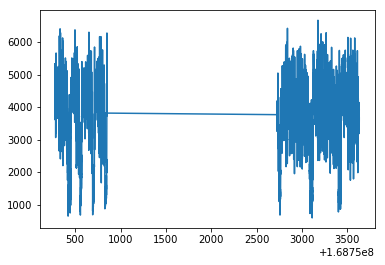

sum of GTI durations in seconds:  1482.75
individual GTI durations in seconds:
575.25
907.5



10408-01-14-08 delta


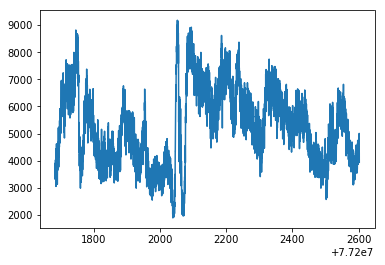

sum of GTI durations in seconds:  918.875



10408-01-17-03 delta


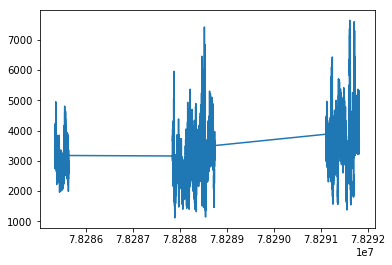

sum of GTI durations in seconds:  1888.25
individual GTI durations in seconds:
290.5
894.875
702.75



10408-01-14-02 delta


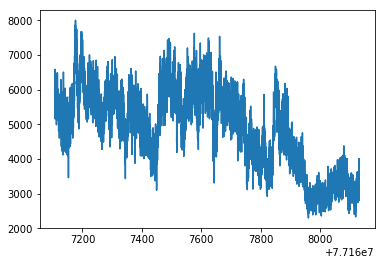

sum of GTI durations in seconds:  1023.875



10408-01-15-03 theta


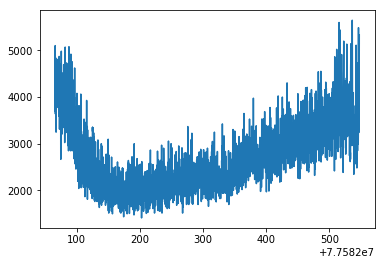

sum of GTI durations in seconds:  482.125



20402-01-43-01 mu


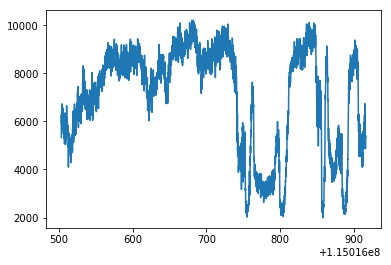

sum of GTI durations in seconds:  412.625



80127-01-01-00 eta


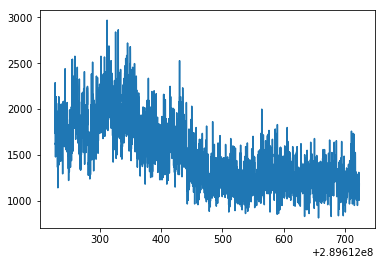

sum of GTI durations in seconds:  496.625



40703-01-20-03 chi


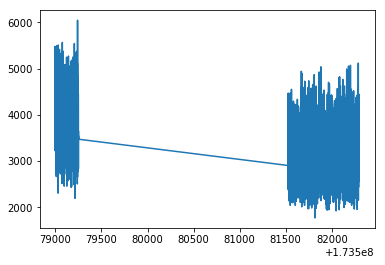

sum of GTI durations in seconds:  1030.5
individual GTI durations in seconds:
255.875
774.625



40703-01-34-02 delta


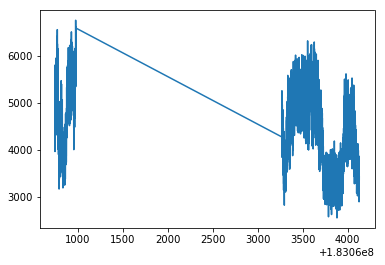

sum of GTI durations in seconds:  1097.5
individual GTI durations in seconds:
234.875
862.625



20402-01-24-01 alpha


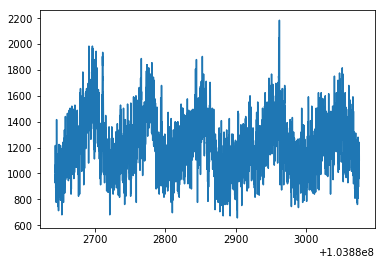

sum of GTI durations in seconds:  431.5



10408-01-14-03 delta


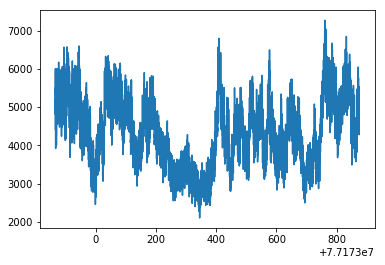

sum of GTI durations in seconds:  1010.25



10408-01-14-07 delta


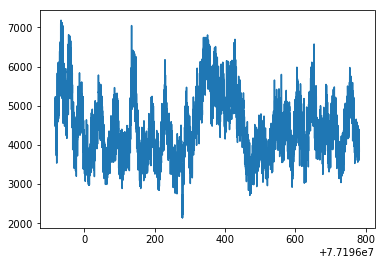

sum of GTI durations in seconds:  865.5



40703-01-41-02 chi


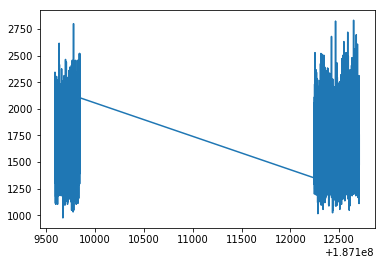

sum of GTI durations in seconds:  717.875
individual GTI durations in seconds:
255.875
462.0



40703-01-20-02 chi


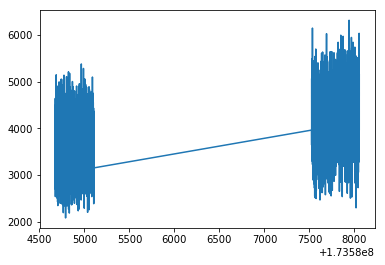

sum of GTI durations in seconds:  965.75
individual GTI durations in seconds:
435.375
530.375



10408-01-18-01 delta


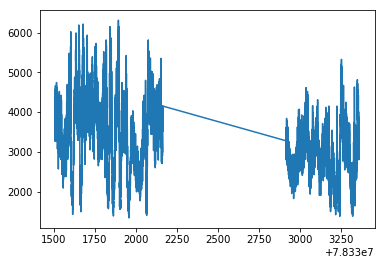

sum of GTI durations in seconds:  1104.875
individual GTI durations in seconds:
656.875
448.0



20402-01-34-00 rho


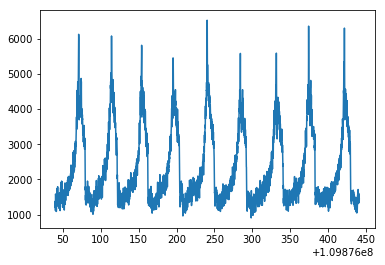

sum of GTI durations in seconds:  401.875



40703-01-41-01 chi


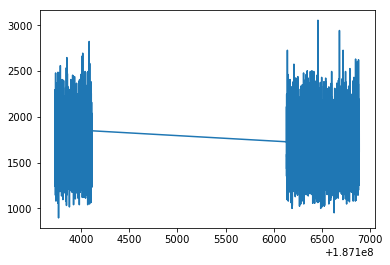

sum of GTI durations in seconds:  1137.875
individual GTI durations in seconds:
383.875
754.0



40703-01-42-03 chi


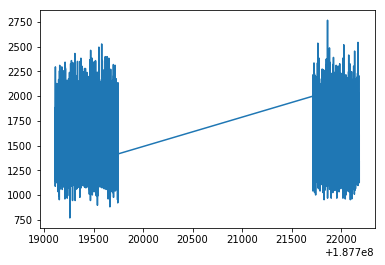

sum of GTI durations in seconds:  1108.75
individual GTI durations in seconds:
639.875
468.875



40703-01-33-01 delta


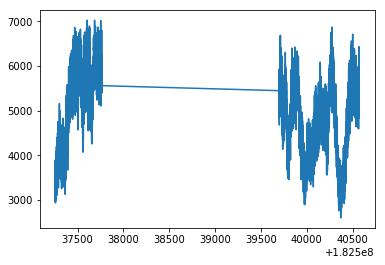

sum of GTI durations in seconds:  1386.375
individual GTI durations in seconds:
511.875
874.5



40703-01-41-03 chi


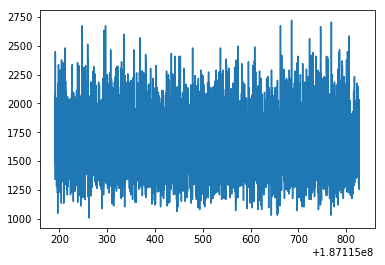

sum of GTI durations in seconds:  636.625



40703-01-14-02 kappa


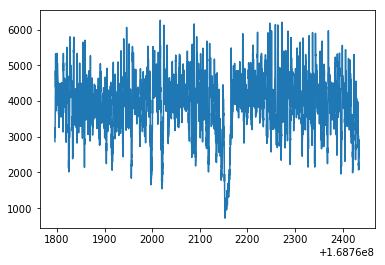

sum of GTI durations in seconds:  639.875



20402-01-30-02 alpha


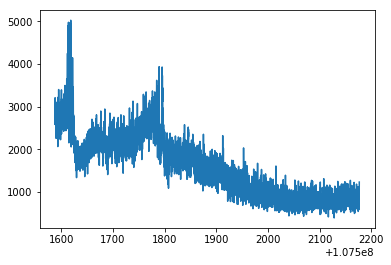

sum of GTI durations in seconds:  589.5



20402-01-43-02 beta


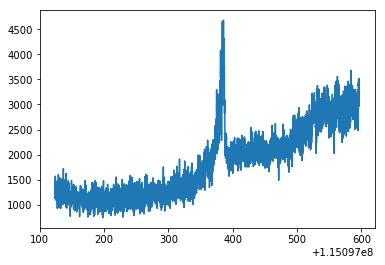

sum of GTI durations in seconds:  472.375
individual GTI durations in seconds:
6.875
465.5



20402-01-52-01 beta


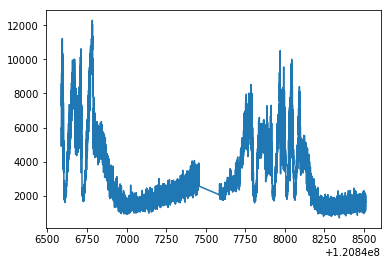

sum of GTI durations in seconds:  1794.5
individual GTI durations in seconds:
46.875
823.875
923.625



33


In [19]:
data_preprocessing.verify_not_segmented_light_curves(lcs, ob_state, seg_ids, lc_ids)

In [108]:
1024*8

8192

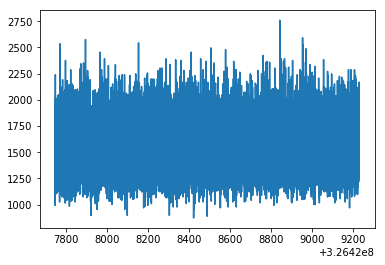

In [103]:
plt.plot(lcs[0][0],lcs[0][1])

In [114]:
np.where( np.array(range(3)) == 1)

(array([1]),)

In [95]:
for x in range(0,100,100):
    print(x)

0


In [97]:
int(len(lcs[760][0])-8192.0)

0

In [96]:
print(1024//0.125)
for start in range(0, int(len(lcs[760][0])-8192.0), 256):
    print(start)

8192.0


In [115]:
np.where(np.array(lc_ids) == "10408-01-17-03")[0][0]

1031

In [126]:
np.where(np.diff(lcs[1031][0]) > 0.125)

(array([2324, 9484]),)

In [125]:
lcs[1031][0][:2325]

array([78285344.75343166, 78285344.87843166, 78285345.00343166, ...,
       78285635.00343166, 78285635.12843166, 78285635.25343166])

In [128]:
lcs[1031][0][2324]-lcs[1031][0][0]

290.5

In [ ]:
2324*0.125

40703-01-38-00 theta


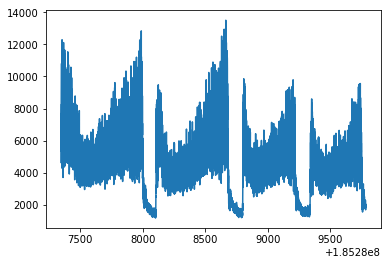

total GTI len in seconds 162128561.22175157



20402-01-38-00 gamma


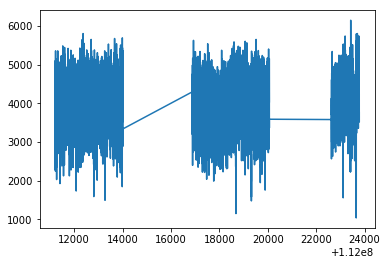

total GTI len in seconds 98020810.3467524
individual GTI len in seconds:
2815.875
3198.25
1151.75



30703-01-33-00 chi


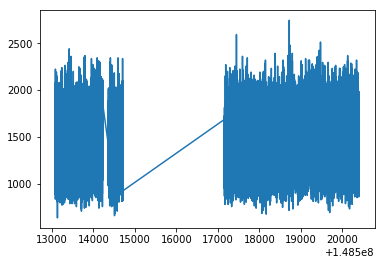

total GTI len in seconds 129955353.7217524
individual GTI len in seconds:
1151.875
354.125
3248.375



20186-03-02-01 theta


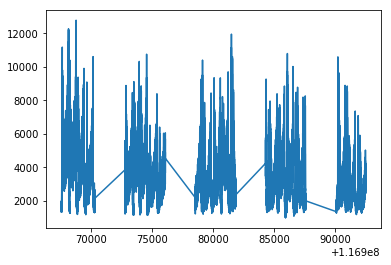

total GTI len in seconds 102368450.8467524
individual GTI len in seconds:
2763.375
3314.625
3314.625
3314.625
2444.125



40703-01-17-01 chi


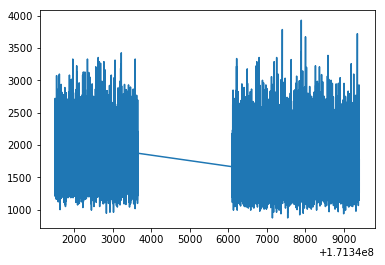

total GTI len in seconds 149930727.73737657
individual GTI len in seconds:
2156.5
3305.625



10408-01-14-00 delta


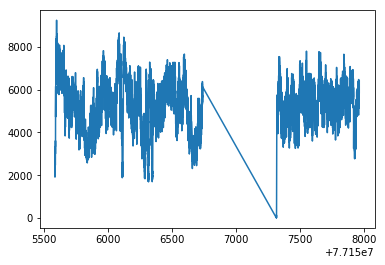

total GTI len in seconds 67513216.9717527
individual GTI len in seconds:
1151.875
646.875



10408-01-25-00 chi


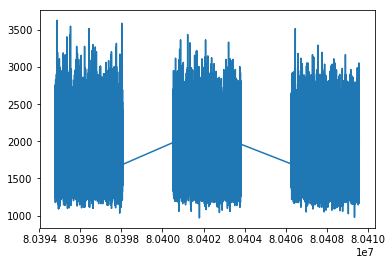

total GTI len in seconds 70358397.1592527
individual GTI len in seconds:
3297.25
3315.875
3315.875



10408-01-36-00 mu


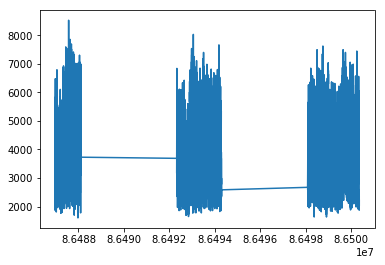

total GTI len in seconds 75687810.8467527
individual GTI len in seconds:
1151.875
1969.375
2270.875



10408-01-17-03 delta


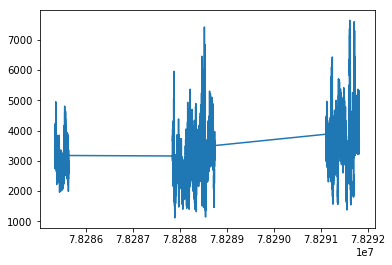

total GTI len in seconds 68505334.8467527
individual GTI len in seconds:
290.5
894.875
702.75



20187-02-01-01 alpha


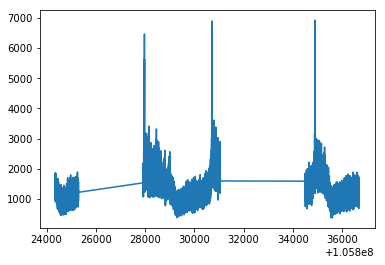

total GTI len in seconds 92607114.4717527
individual GTI len in seconds:
955.625
3149.875
2203.0



10408-01-16-03 theta


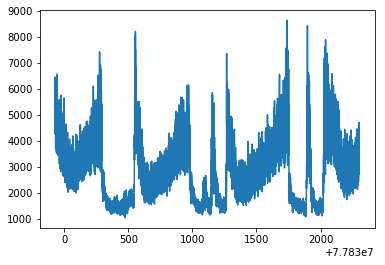

total GTI len in seconds 68103264.4717527



20402-01-08-00 chi


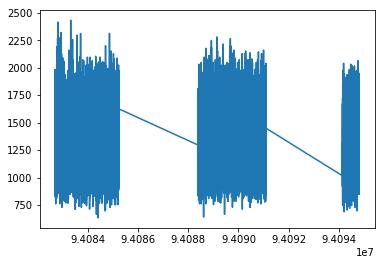

total GTI len in seconds 82332969.4717527
individual GTI len in seconds:
2559.875
2720.375
672.375



40703-01-41-02 chi


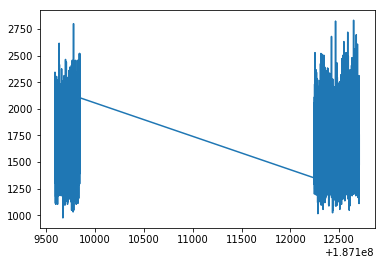

total GTI len in seconds 163723617.09675157
individual GTI len in seconds:
255.875
462.0



40703-01-20-00 chi


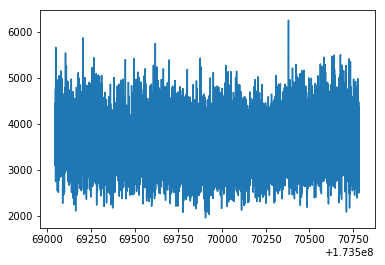

total GTI len in seconds 151874437.86237657



20402-01-27-03 chi


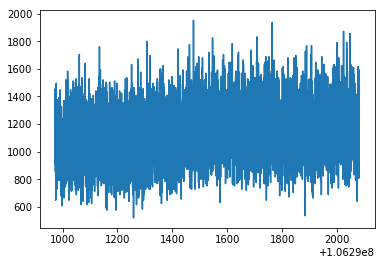

total GTI len in seconds 93005569.7842527



40703-01-22-00 beta


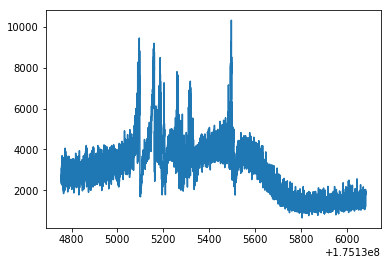

total GTI len in seconds 153244072.40925157



10408-01-12-00 phi


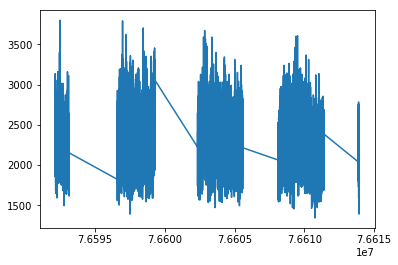

total GTI len in seconds 67037199.4717527
individual GTI len in seconds:
1023.875
2733.125
3242.25
3312.25
71.625



10408-01-14-08 delta


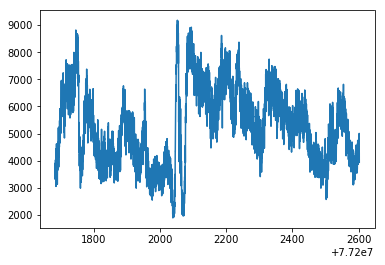

total GTI len in seconds 67552276.9717527



40703-01-14-02 kappa


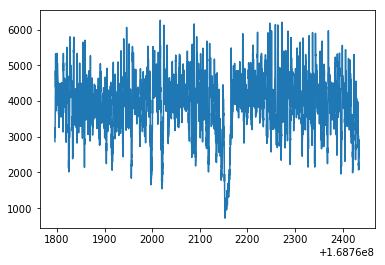

total GTI len in seconds 147667130.84675157



10408-01-15-00 theta


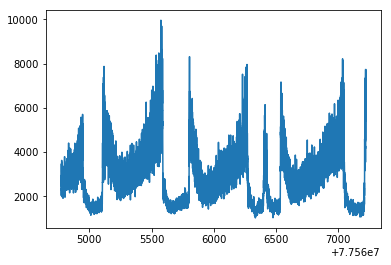

total GTI len in seconds 67871319.4717527



10408-01-09-00 phi
No data



20402-01-37-02 gamma


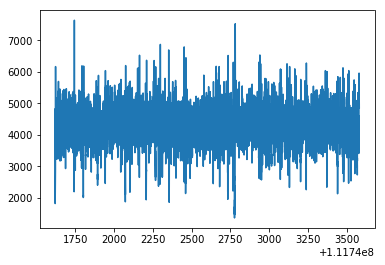

total GTI len in seconds 97775633.0498774
individual GTI len in seconds:
1422.875
537.375



20402-01-45-01 mu


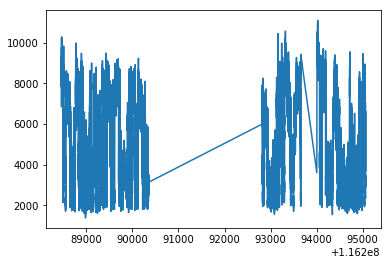

total GTI len in seconds 101758181.2217524
individual GTI len in seconds:
34.875
1866.0
855.375
1061.0



10408-01-16-02 theta


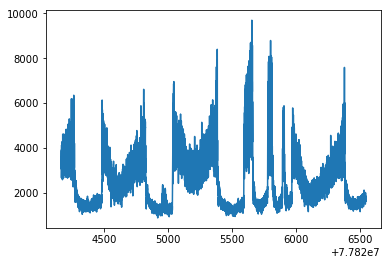

total GTI len in seconds 68098224.4717527



40703-01-19-01 beta


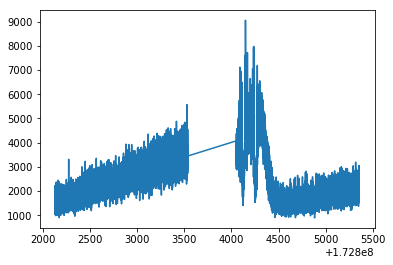

total GTI len in seconds 151204684.20612657
individual GTI len in seconds:
1407.875
1302.125



20186-03-02-06 chi


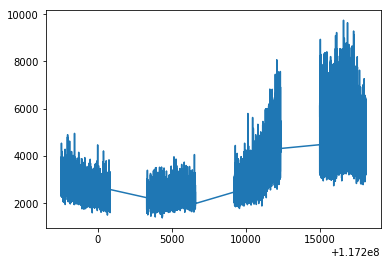

total GTI len in seconds 102565856.6436274
individual GTI len in seconds:
288.0
2895.625
127.875
3042.0
3124.125
3110.625



10408-01-16-01 theta


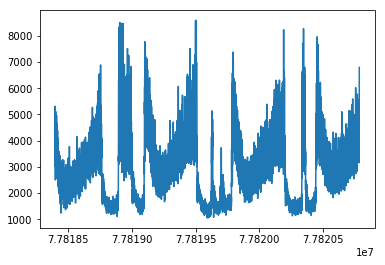

total GTI len in seconds 68093184.4717527



40703-01-31-00 gamma


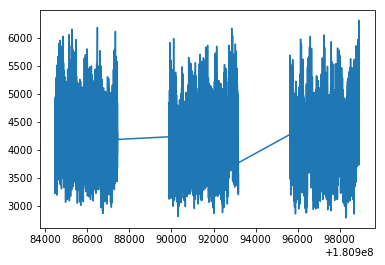

total GTI len in seconds 158374067.58112657
individual GTI len in seconds:
2974.75
3306.875
3306.75



20402-01-39-00 gamma
No data



40703-01-42-03 chi


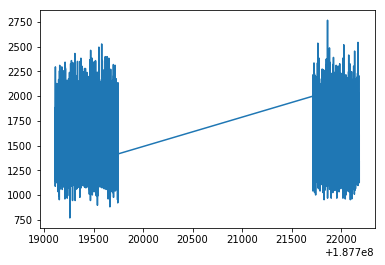

total GTI len in seconds 164256911.22175157
individual GTI len in seconds:
639.875
468.875



20402-01-07-00 chi
No data



10408-01-27-00 chi
No data



40703-01-20-02 chi
No data



40703-01-23-01 rho


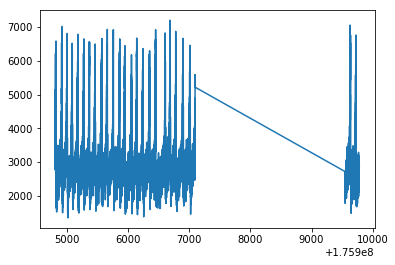

total GTI len in seconds 153921056.84675157
individual GTI len in seconds:
2291.875
234.75



10408-01-23-00 chi
No data



20402-01-04-00 chi
No data



20402-01-52-01 beta
No data



20402-01-41-01 delta
No data



10408-01-31-00 chi
No data



40703-01-14-00 kappa


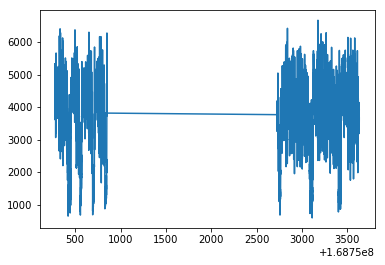

total GTI len in seconds 147659426.90925157
individual GTI len in seconds:
575.25
907.5



20402-01-54-00 delta
No data



10408-01-10-00 beta
No data



10408-01-14-04 delta


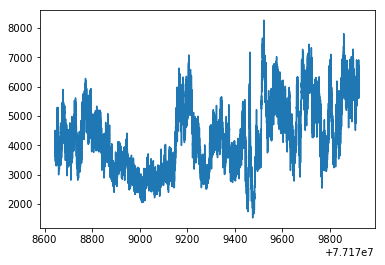

total GTI len in seconds 67532432.8467527



40703-01-17-00 chi
No data



20402-01-53-01 mu
No data



10408-01-15-03 theta


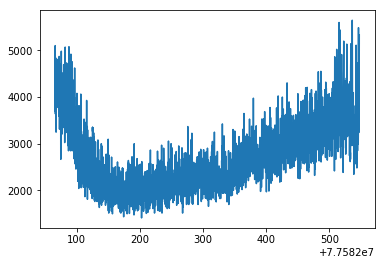

total GTI len in seconds 67884728.8467527



20402-01-26-02 chi


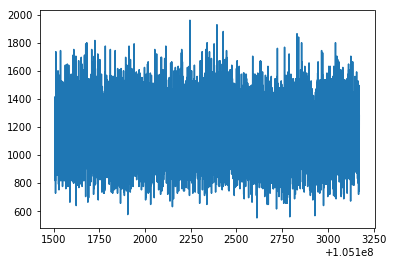

total GTI len in seconds 91965274.8467527



20402-01-28-00 alpha


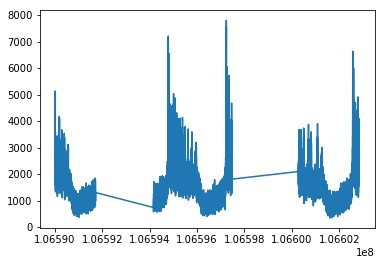

total GTI len in seconds 93277486.9717527
individual GTI len in seconds:
1710.25
3312.375
2566.875



30703-01-28-01 rho


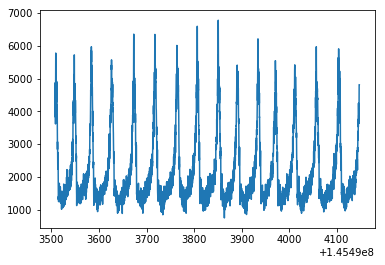

total GTI len in seconds 127307378.8467524



10408-01-16-04 theta


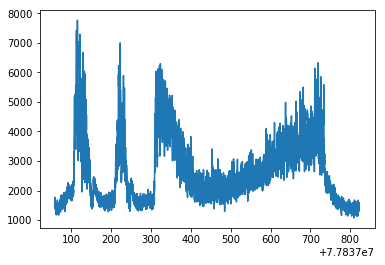

total GTI len in seconds 68108094.4717527



20402-01-50-00 chi


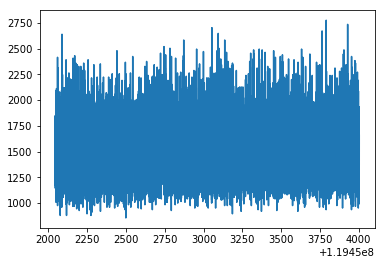

total GTI len in seconds 104522252.8467524



20402-01-39-02 gamma


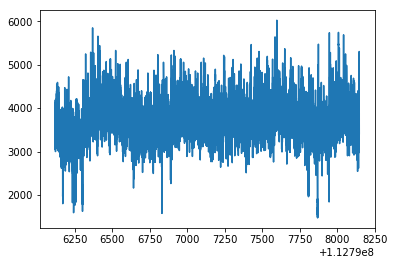

total GTI len in seconds 98698377.6436274
individual GTI len in seconds:
20.875
2006.625



10408-01-19-02 phi


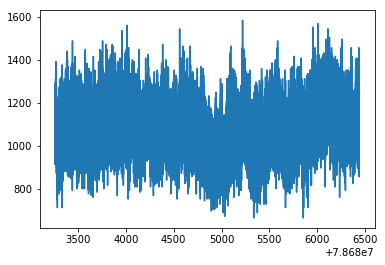

total GTI len in seconds 68850634.4561277



40703-01-34-00 delta


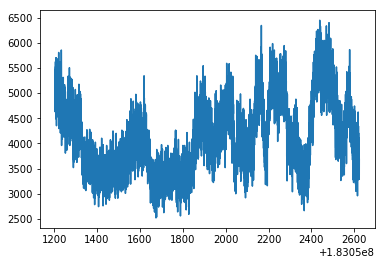

total GTI len in seconds 160171045.56550157



40703-01-20-01 chi


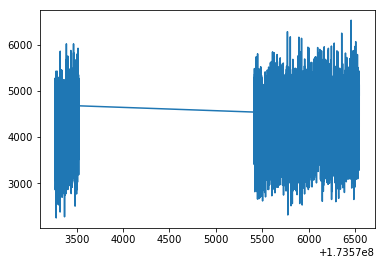

total GTI len in seconds 151879474.25300157
individual GTI len in seconds:
255.875
1130.75



20402-01-42-00 delta


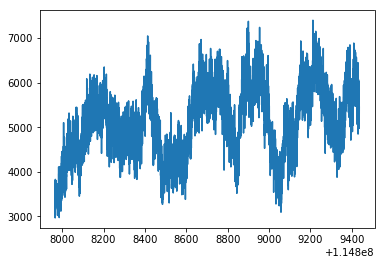

total GTI len in seconds 100458257.1592524
individual GTI len in seconds:
7.875
1460.5



20402-01-12-00 chi


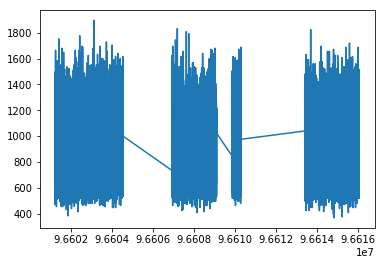

total GTI len in seconds 84539050.5342527
individual GTI len in seconds:
7.875
3315.875
2187.875
451.625
2662.375



10408-01-14-01 delta


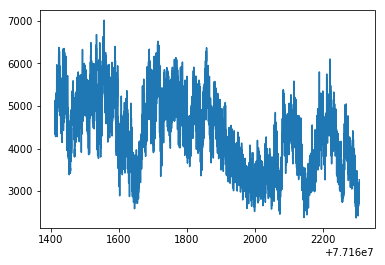

total GTI len in seconds 67517018.8467527



20402-01-20-00 chi


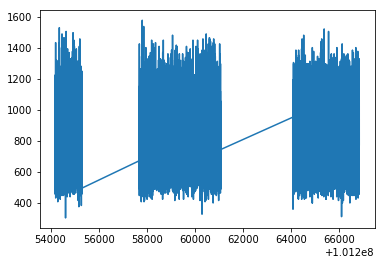

total GTI len in seconds 88608480.4092527
individual GTI len in seconds:
1128.375
3383.125
2767.5



20186-03-02-04 theta


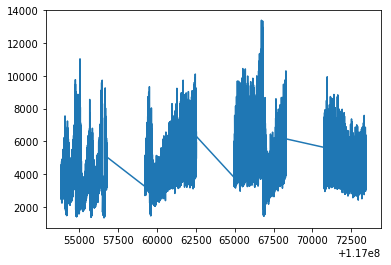

total GTI len in seconds 102439248.8467524
individual GTI len in seconds:
2923.5
3313.875
3313.75
2679.75



10408-01-43-00 chi


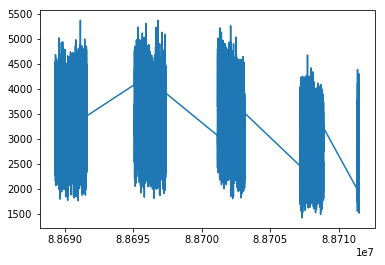

total GTI len in seconds 77622554.8467527
individual GTI len in seconds:
2327.0
2281.625
1980.5
1743.25
157.625



20402-01-55-00 gamma


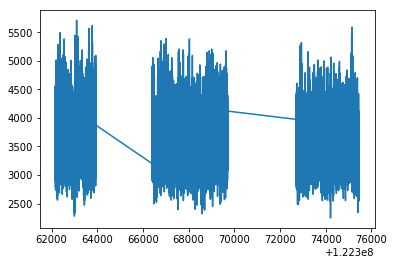

total GTI len in seconds 107078536.6905024
individual GTI len in seconds:
1798.625
3306.625
2780.25



40703-01-38-02 chi


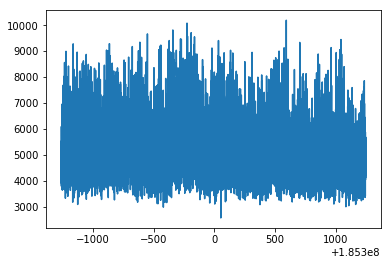

total GTI len in seconds 162138588.72175157



30402-01-12-03 chi


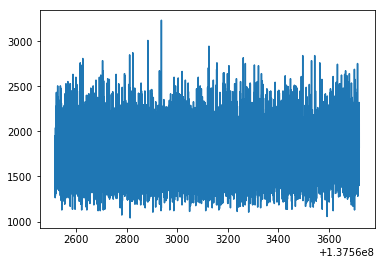

total GTI len in seconds 120368254.1280024



20402-01-29-00 chi


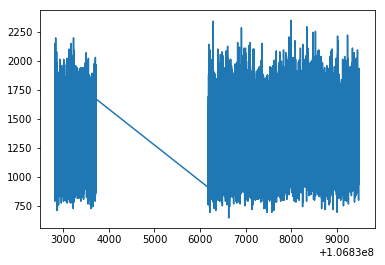

total GTI len in seconds 93484550.0342527
individual GTI len in seconds:
21.875
880.25
3311.625



20186-03-02-03 theta


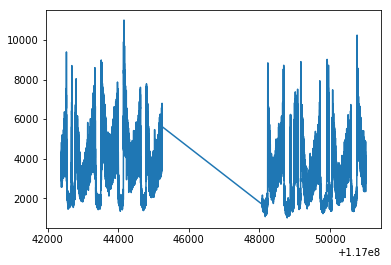

total GTI len in seconds 102419634.9561274
individual GTI len in seconds:
2861.5
2928.125



20402-01-05-00 chi


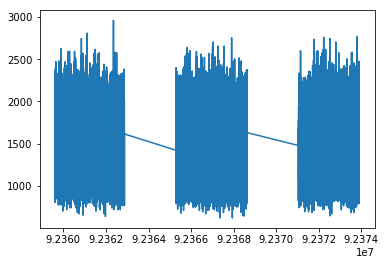

total GTI len in seconds 80827164.4717527
individual GTI len in seconds:
3267.375
3352.625
2856.75



20402-01-34-01 rho


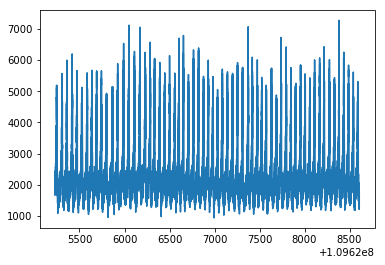

total GTI len in seconds 95925031.6748777



40703-01-38-01 chi


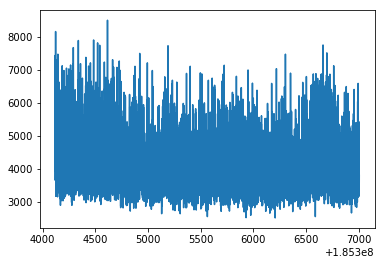

total GTI len in seconds 162143628.72175157



10408-01-19-00 phi


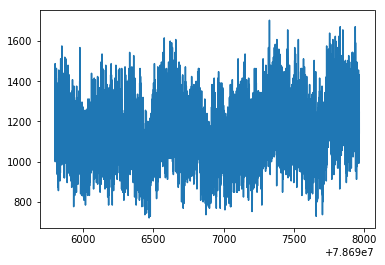

total GTI len in seconds 68860720.2530027



40703-01-27-00 omega


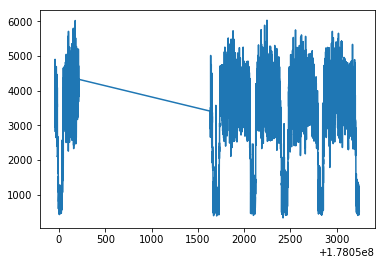

total GTI len in seconds 155796589.37800157
individual GTI len in seconds:
255.875
1609.625



20402-01-43-01 mu


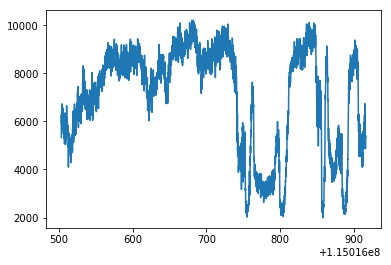

total GTI len in seconds 100639801.5030024



20402-01-31-02 rho


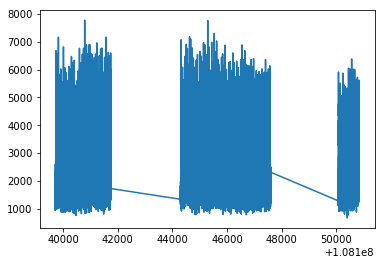

total GTI len in seconds 94631986.9717527
individual GTI len in seconds:
2047.875
3316.625
789.0



40703-01-34-01 delta


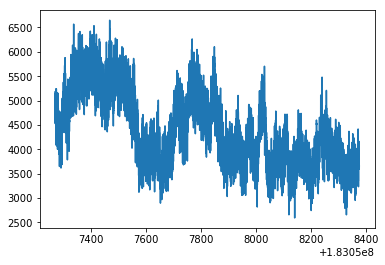

total GTI len in seconds 160176079.65925157



20402-01-52-02 beta


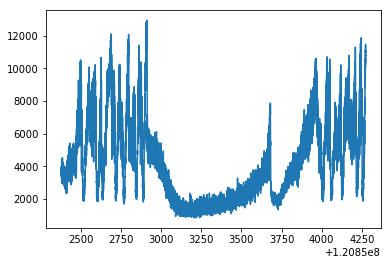

total GTI len in seconds 105747488.8780024
individual GTI len in seconds:
13.875
1877.75



20402-01-31-01 rho


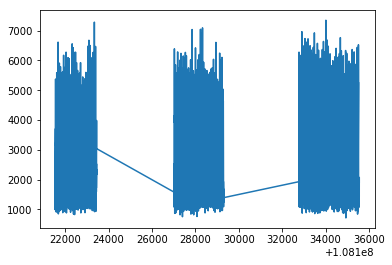

total GTI len in seconds 94618610.8467527
individual GTI len in seconds:
1919.875
2296.625
2790.125



20402-01-32-00 rho


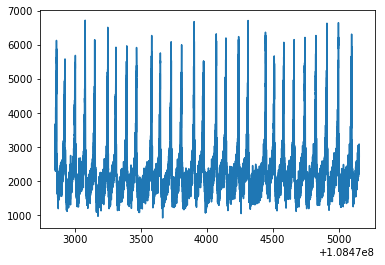

total GTI len in seconds 94915760.8467527



30402-01-11-00 chi


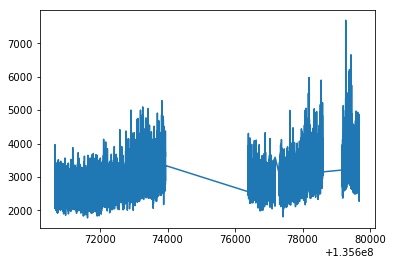

total GTI len in seconds 118719722.8467524
individual GTI len in seconds:
3276.25
798.375
1279.875
512.0



10408-01-34-00 mu


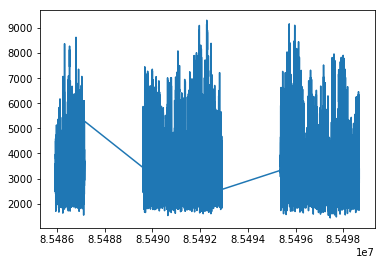

total GTI len in seconds 74811340.5186277
individual GTI len in seconds:
1241.625
3309.375
3309.5



30402-01-12-02 chi


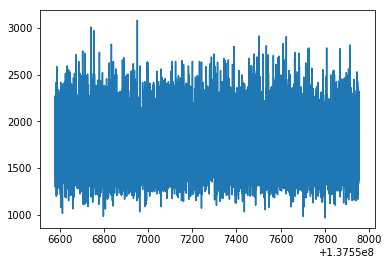

total GTI len in seconds 120363212.1592524



30703-01-35-00 chi


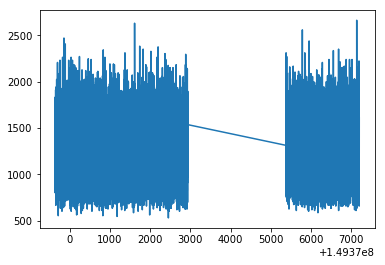

total GTI len in seconds 130705053.7217524
individual GTI len in seconds:
3307.5
1823.0



20402-01-30-02 alpha


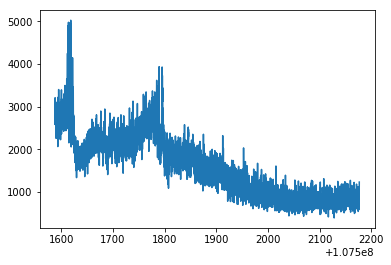

total GTI len in seconds 94064404.7686277



40703-01-13-00 gamma


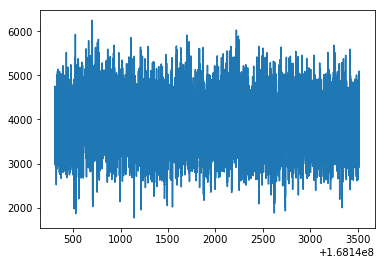

total GTI len in seconds 147125578.36237657



40703-01-34-02 delta


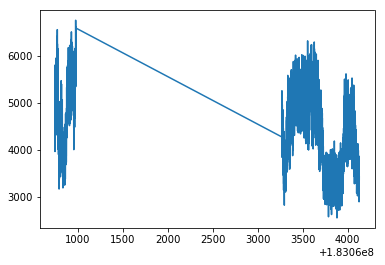

total GTI len in seconds 160181113.64362657
individual GTI len in seconds:
234.875
862.625



30703-01-28-00 rho


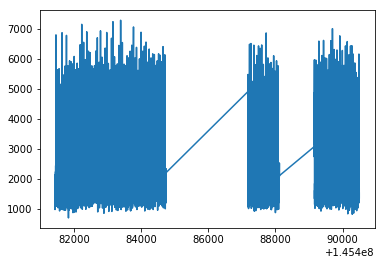

total GTI len in seconds 127304187.2842524
individual GTI len in seconds:
3317.375
934.25
1344.375



20402-01-44-00 beta


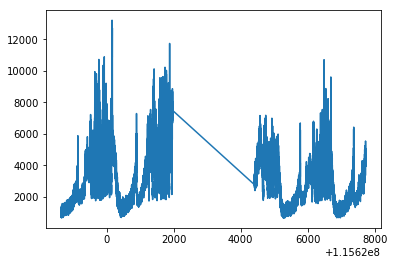

total GTI len in seconds 101174259.5967524
individual GTI len in seconds:
3319.75
3319.5



20402-01-24-01 alpha


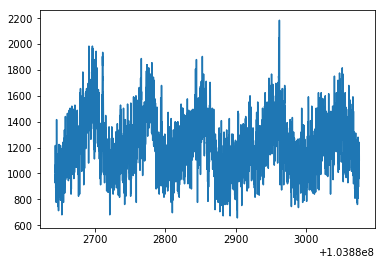

total GTI len in seconds 90897690.5186277



20402-01-13-00 chi


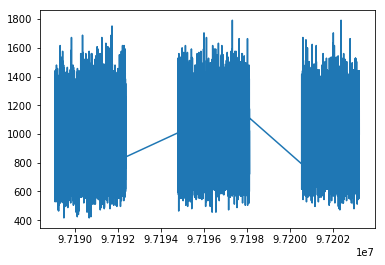

total GTI len in seconds 85052831.7217527
individual GTI len in seconds:
3287.375
3331.5
2679.875



20402-01-09-00 chi


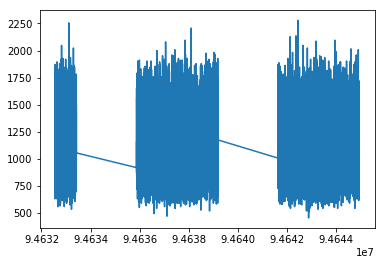

total GTI len in seconds 82814329.5030027
individual GTI len in seconds:
6.875
867.25
3312.375
3312.375



20402-01-53-00 beta


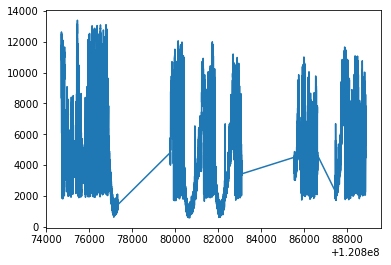

total GTI len in seconds 105777739.8155024
individual GTI len in seconds:
2614.0
3312.375
1079.0
1419.25



10408-01-33-00 chi


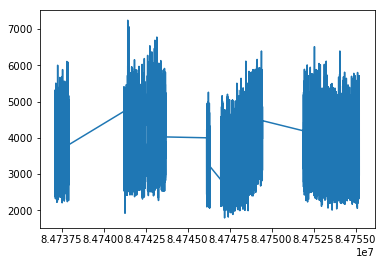

total GTI len in seconds 74160816.0811277
individual GTI len in seconds:
820.875
1271.75
1080.25
188.25
2483.5
3320.125



20402-01-45-02 theta


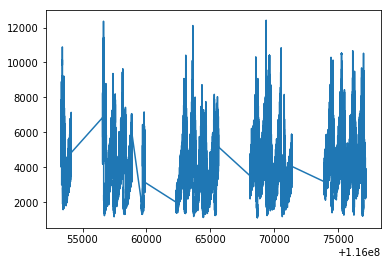

total GTI len in seconds 101567512.1592524
individual GTI len in seconds:
21.875
753.0
1650.625
637.0
268.125
3306.375
3306.25
3233.5



10408-01-32-00 chi


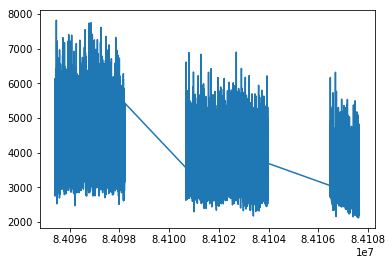

total GTI len in seconds 73594186.9717527
individual GTI len in seconds:
2805.625
3312.75
1175.0



10408-01-11-00 phi


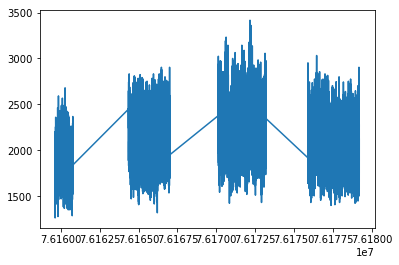

total GTI len in seconds 66656792.0186277
individual GTI len in seconds:
1151.875
2661.625
3090.25
3314.625



10408-01-29-00 chi


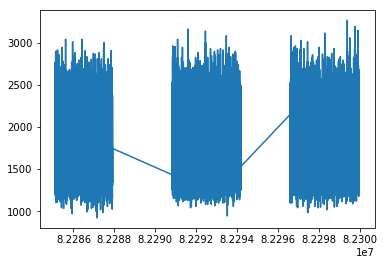

total GTI len in seconds 72012478.7842527
individual GTI len in seconds:
2815.875
3358.25
3390.75



30703-01-29-00 rho


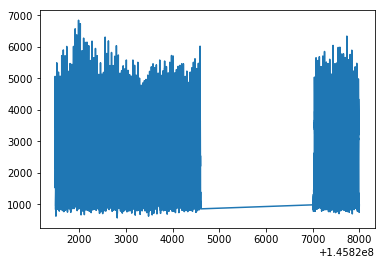

total GTI len in seconds 127599502.8467524
individual GTI len in seconds:
3125.875
985.25



10258-01-10-00 lambda


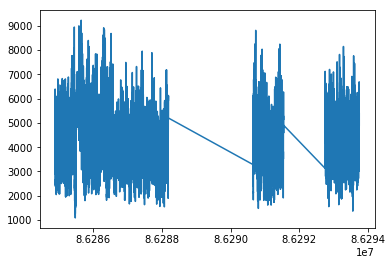

total GTI len in seconds 75507024.4717527
individual GTI len in seconds:
3303.625
895.875
994.875



10408-01-17-02 phi


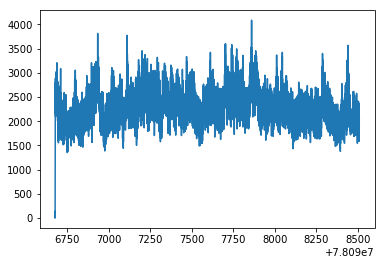

total GTI len in seconds 68336195.7061277



40703-01-30-00 kappa


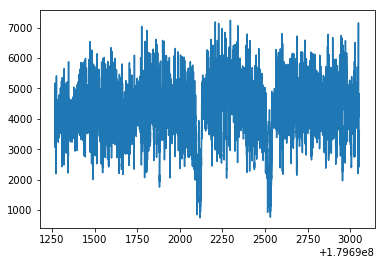

total GTI len in seconds 157231421.26862657



20402-01-45-03 beta


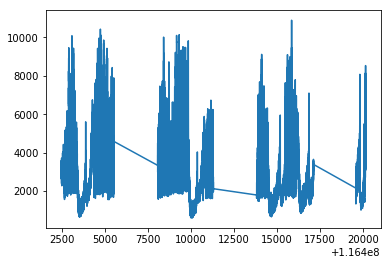

total GTI len in seconds 101867642.8467524
individual GTI len in seconds:
3071.875
3242.5
3309.875
576.0



40703-01-24-00 kappa


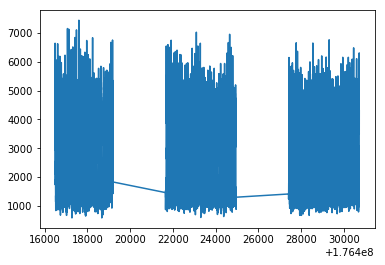

total GTI len in seconds 154376875.29987657
individual GTI len in seconds:
2723.5
3304.25
3304.25



40703-01-16-01 chi


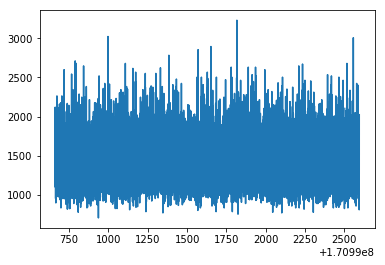

total GTI len in seconds 149618519.97175157



40703-01-36-02 theta


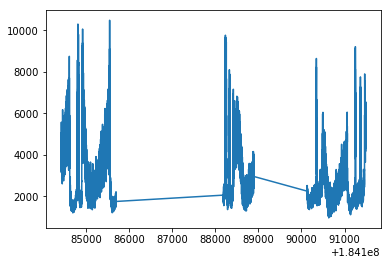

total GTI len in seconds 161167552.98737657
individual GTI len in seconds:
1271.875
711.0
1357.875



20402-01-51-00 chi


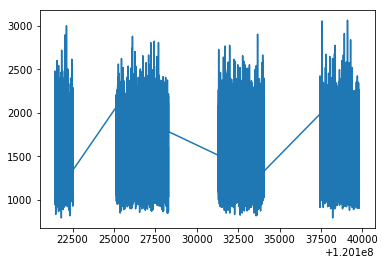

total GTI len in seconds 105122332.9873774
individual GTI len in seconds:
54.875
1040.375
3162.25
2748.0
2381.875



40703-01-30-01 kappa


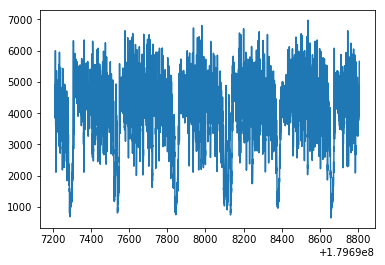

total GTI len in seconds 157236454.59675157



40703-01-22-01 beta


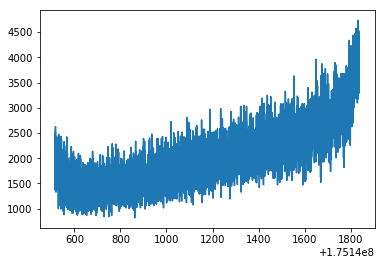

total GTI len in seconds 153249107.81550157



40703-01-19-00 beta


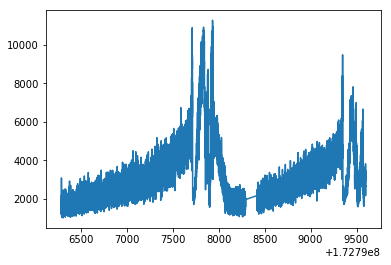

total GTI len in seconds 151199649.01862657
individual GTI len in seconds:
2004.125
1179.625



20186-03-02-05 chi


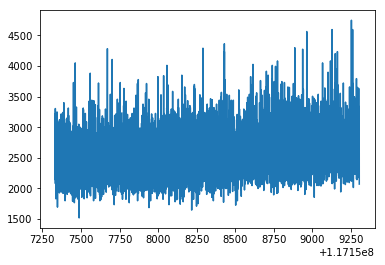

total GTI len in seconds 102514391.2217524



40703-01-21-01 chi


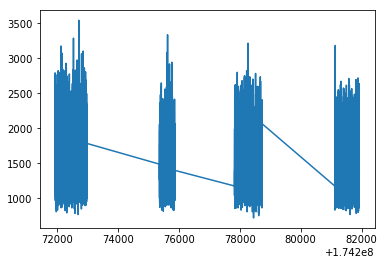

total GTI len in seconds 152496682.84675157
individual GTI len in seconds:
1052.375
496.0
908.375
805.5



10408-01-41-00 nu


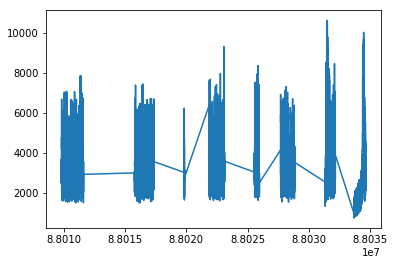

total GTI len in seconds 77030322.1436277
individual GTI len in seconds:
1817.25
1602.0
65.125
1252.75
413.875
1191.625
858.625
954.625



20402-01-22-00 alpha


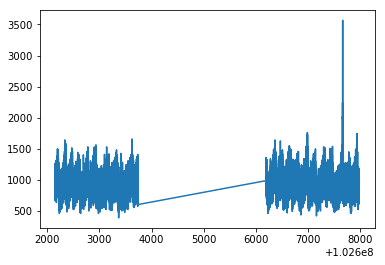

total GTI len in seconds 89781984.4717527
individual GTI len in seconds:
1597.375
1788.5



20402-01-35-00 kappa


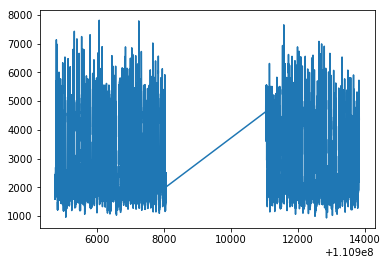

total GTI len in seconds 97049605.4092524
individual GTI len in seconds:
3317.25
2791.5



40703-01-30-02 kappa


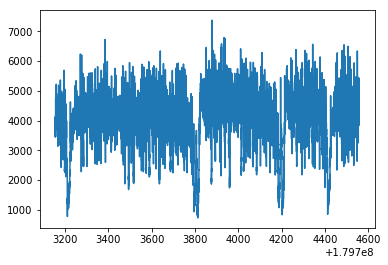

total GTI len in seconds 157241488.03425157



20402-01-37-00 gamma


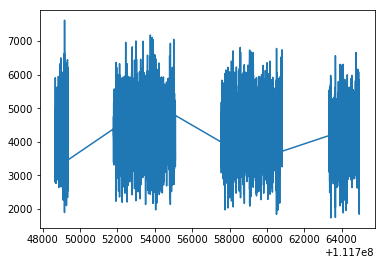

total GTI len in seconds 97794325.3467524
individual GTI len in seconds:
683.625
3310.0
3261.375
1623.125



10408-01-15-01 theta


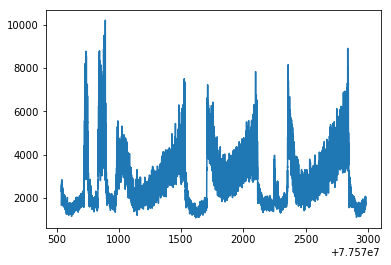

total GTI len in seconds 67876359.4717527



20187-02-01-00 alpha
No data



40703-01-18-00 beta
No data



10408-01-30-00 chi
No data



20402-01-57-00 gamma
No data



10408-01-15-05 theta
No data



40703-01-41-03 chi
No data



20402-01-27-02 rho
No data



20402-01-37-01 lambda
No data



40703-01-12-00 kappa
No data



20402-01-17-00 chi
No data



40703-01-13-01 omega
No data



10408-01-40-00 nu


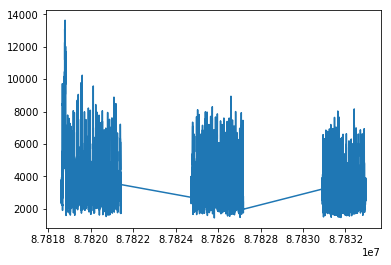

total GTI len in seconds 76853832.7842527
individual GTI len in seconds:
2814.125
2465.25
2052.5



20402-01-41-03 delta


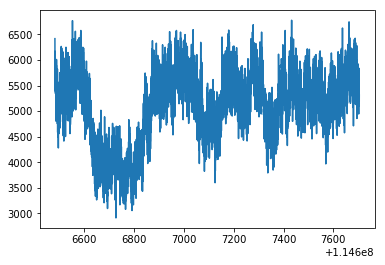

total GTI len in seconds 100281740.6748774



40703-01-35-01 beta


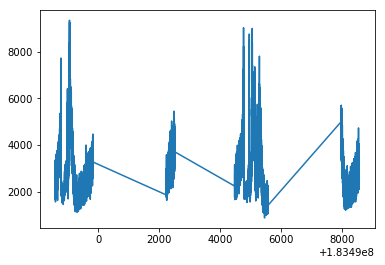

total GTI len in seconds 160561256.84675157
individual GTI len in seconds:
1250.625
285.75
1099.75
597.25



20402-01-36-01 lambda


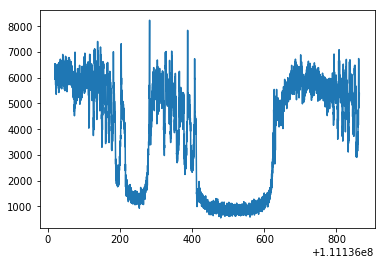

total GTI len in seconds 97244755.3467524



30703-01-36-00 chi


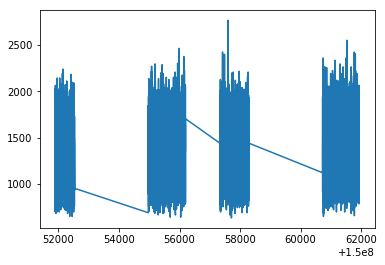

total GTI len in seconds 131304196.8467524
individual GTI len in seconds:
647.875
1226.875
958.25
1211.875



10408-01-16-00 theta


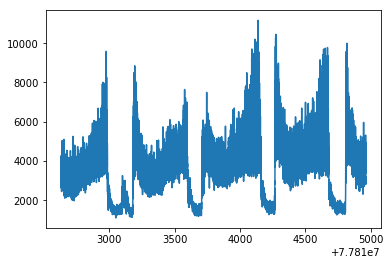

total GTI len in seconds 68088091.9717527



20402-01-25-00 chi


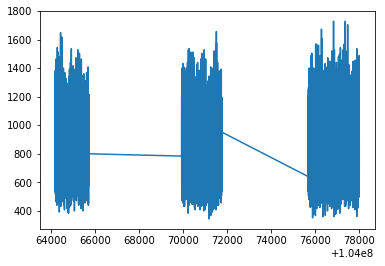

total GTI len in seconds 91068252.8467527
individual GTI len in seconds:
40.75
1495.875
1823.375
2317.25



10408-01-14-07 delta


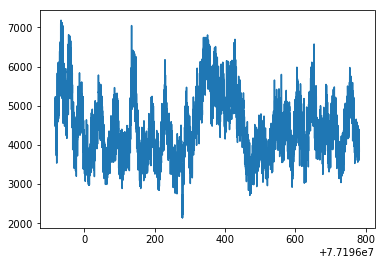

total GTI len in seconds 67547184.4717527



40703-01-26-00 kappa


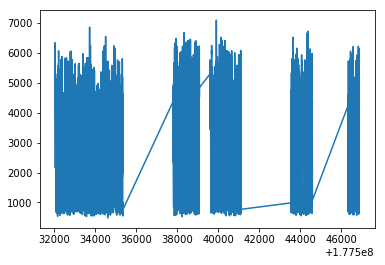

total GTI len in seconds 155353518.69050157
individual GTI len in seconds:
3318.25
1285.0
1521.625
1035.875
555.25



20402-01-27-01 chi


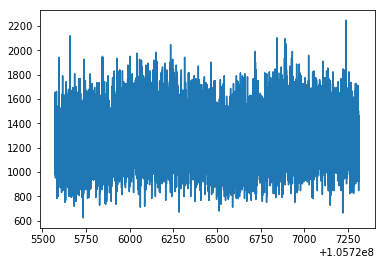

total GTI len in seconds 92511400.7373777



20402-01-11-00 chi


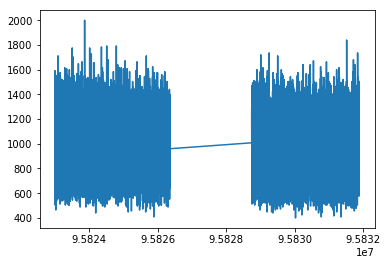

total GTI len in seconds 83852897.8467527
individual GTI len in seconds:
3358.5
3141.625



20402-01-32-01 rho


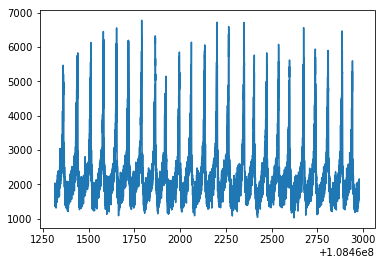

total GTI len in seconds 94905106.8467527



20402-01-40-00 gamma


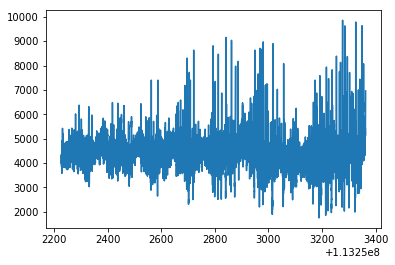

total GTI len in seconds 99096692.2998774
individual GTI len in seconds:
5.875
1127.375



10408-01-35-00 mu


In [ ]:
import matplotlib.pyplot as plt

def verify_not_segmented_light_curves(lcs, ob_state, seg_ids, lc_ids):
    """
    Plot and show GTI length of the light curves which were not segmented
    
    Parameters:
    --------------
    lcs: list of ndarrays 
        ndarrays of shape (3,light_curve_length) containing time, count rate and count rate error data
        
    ob_state: dict
        Classifications of light curves in the form {observation_ID: class_label}
        
    seg_ids: list of strings
        identifiers for segment light curves in the form of  "{}_{}".format(observation_ID, integer)
    
    lc_ids: list of strings
        identifiers for light curvesin the for of observation_ID, e.g. "10408-01-17-03"
    
    """
    rejected_lcs_with_label = 0
    for k,v in ob_state.items():
        if k not in [x.split("_")[0] for x in seg_ids]:
            print(k, v)
            try:
                n = np.where(np.array(lc_ids) == k)[0][0]
                plt.plot(lcs[n][0], lcs[n][1])
                plt.show()
                print("total GTI len in seconds", lcs[n][0][-1]-lcs[n][0][-1]/8)
                time_deltas = lcs[n][0][1:]-lcs[n][0][:-1]
                gaps = np.where(time_deltas>0.125)[0]
                if len(gaps)>0:
                    print("individual GTI len in seconds:")
                    for gap_ind, gap in enumerate(gaps):
                        if gap_ind == 0:
                            print(gap*0.125)
                        else:
                            print((gap-(gaps[gap_ind-1]+1))*0.125)

                        if gap == gaps[-1]:
                            print((len(lcs[n][0])-(gap+1))*0.125)
            except:
                print("No data")
            rejected_lcs_with_label+=1
            print("\n\n")
    print(rejected_lcs_with_label)

# segmentation of 1024 second segments

In [18]:
clean_belloni = open('{}/1915Belloniclass_updated.dat'.format(data_dir))
lines = clean_belloni.readlines()
states = lines[0].split()
belloni_clean = {}
for h,l in zip(states, lines[1:]):
    belloni_clean[h] = l.split()
    #state: obsID1, obsID2...
ob_state = {}
for state, obs in belloni_clean.items():
    if state == "chi1" or state == "chi2" or state == "chi3" or state == "chi4": state = "chi"
    for ob in obs:
        ob_state[ob] = state

        
# inverse the ob_state dictionary, so that inv_ob_state contains {"state name" : [list of observation IDs], ...}

inv_ob_state = {}
for k, v in ob_state.items():
    inv_ob_state[v] = inv_ob_state.get(v, [])
    inv_ob_state[v].append(k)

In [99]:
n = 0
for k,v in inv_ob_state.items():
    n += len(v)
print(n)

216


In [98]:
v

'alpha'

In [22]:
labelled_light = []
for k,v in ob_state.items():
    if k in [x.split("_")[0] for x in seg_ids]:
        labelled_light.append(v)
print(labelled_light)

['theta', 'gamma', 'chi', 'theta', 'chi', 'delta', 'chi', 'mu', 'alpha', 'theta', 'chi', 'chi', 'chi', 'beta', 'phi', 'theta', 'gamma', 'mu', 'theta', 'beta', 'chi', 'theta', 'gamma', 'gamma', 'chi', 'chi', 'rho', 'chi', 'chi', 'delta', 'chi', 'delta', 'beta', 'delta', 'chi', 'mu', 'chi', 'alpha', 'chi', 'gamma', 'phi', 'delta', 'chi', 'delta', 'chi', 'chi', 'theta', 'chi', 'gamma', 'chi', 'chi', 'chi', 'theta', 'chi', 'rho', 'chi', 'phi', 'omega', 'rho', 'delta', 'beta', 'rho', 'rho', 'chi', 'mu', 'chi', 'chi', 'gamma', 'rho', 'beta', 'chi', 'chi', 'beta', 'chi', 'theta', 'chi', 'phi', 'chi', 'rho', 'lambda', 'phi', 'kappa', 'beta', 'kappa', 'chi', 'theta', 'chi', 'kappa', 'beta', 'beta', 'chi', 'chi', 'nu', 'alpha', 'kappa', 'kappa', 'gamma', 'theta', 'alpha', 'beta', 'chi', 'gamma', 'theta', 'rho', 'lambda', 'kappa', 'chi', 'omega', 'nu', 'delta', 'beta', 'chi', 'theta', 'chi', 'kappa', 'chi', 'chi', 'rho', 'mu', 'chi', 'kappa', 'delta', 'chi', 'chi', 'nu', 'omega', 'kappa', 'chi', 

In [23]:
np.unique(labelled_light, return_counts=True)

(array(['alpha', 'beta', 'chi', 'delta', 'eta', 'gamma', 'kappa', 'lambda',
        'mu', 'nu', 'omega', 'phi', 'rho', 'theta'], dtype='<U6'),
 array([ 6, 14, 70, 12,  2, 11,  9,  3,  6,  3,  3,  9, 17, 17]))

In [95]:
for x in [x.split("_")[0] for x in seg_ids]:
    if x in ob_state.keys():
        labelled_light+=1
print(labelled_light)

2212


In [82]:
from src import convert_belloni

## read data from Lucy's file with clean labels
def convert_belloni_clean(turned=True):
    ## cleaned version; without observations that have light curves
    ## with more than one class
    file = open("/data/jkok1g14/autoencoders-series-outliers/notebooks/Huppenkothen_comparison/1915Belloniclass_updated.dat", "r")
    lines = file.readlines()
    header = lines[0].split()
    belloni_clean = {}
    for h,l in zip(header, lines[1:]):
        belloni_clean[h] = l.split()
    
    if turned:
        belloni_clean_turned = turn_states(belloni_clean)
        return belloni_clean_turned
    else:
        return belloni_clean
    
## turn around conversion (just in case):
def turn_states(states, remove_dashes = False):
    turned_states = {}
    for k,lis in states.items():
        for l in lis:
            if remove_dashes:
                turned_states[l.translate(None, "-")] = k
            else:
                turned_states[l] = k
    return turned_states

## directly lifted from Belloni+ 2000
belloni_states = convert_belloni.main()
belloni_turned = turn_states(belloni_states)

## from Lucy's file with labels only for observations
## where the class does not change during the observation
belloni_clean_turned = convert_belloni_clean()

In [123]:
# https://github.com/dhuppenkothen/BlackHoleML/blob/master/notebooks/GRS1915_SupervisedClassification.ipynb

# chi       762
# theta     189
# rho       157
# gamma     151
# beta      138
# phi       106
# kappa      95
# mu         63
# delta      55
# eta        46
# nu         42
# lambda     35
# alpha      28
# omega      17

15

In [73]:
lcs[1][0][680]

90601722.37843166

In [33]:
potential_lcs = 0

for lc in lcs:
    dts = lc[0][1:]-lc[0][:-1]
    gaps = np.where(dts>0.125)[0]
    if len(gaps) == 0 and len(lc[0])>=1024/0.125:
        potential_lcs+=1
        continue
    else:
        for gap_ind, gap in enumerate(gaps):
            if gap_ind == 0:
                gti_len =  gap/0.125
                if gti_len>=1024:
                    potential_lcs+=1
                    break
                    
            elif gap == gaps[-1]:
                gti_len = (len(lc[0])-gap+1)/0.125
                if gti_len>=1024:
                    potential_lcs+=1
                    break
            else:
                gti_len = (gap-(gaps[gap_ind-1]+1))/0.125
                if gti_len>=1024:
                    potential_lcs+=1
                    break

In [34]:
potential_lcs

1484

In [76]:
'grs1915_supervised_probabilities_withobsids.dat'

1776

In [ ]:
file = open("/data/jkok1g14/autoencoders-series-outliers/notebooks/Huppenkothen_comparison/1915Belloniclass_updated.dat", "r")
lines = file.readlines()

In [124]:
with open("/data/jkok1g14/autoencoders-series-outliers/notebooks/Huppenkothen_comparison/grs1915_supervised_probabilities_withobsids.dat") as file: # Use file to refer to the file object

    probabilities = file.read()

In [129]:
len(probabilities.split("\n")[1:])

7329